In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


 # Signal flow of the Drosophila larva brain

 ## Imports and functions

In [1]:
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.embed import LaplacianSpectralEmbed
from graspy.plot import heatmap, pairplot
from graspy.simulations import sbm
from graspy.utils import get_lcc

from src.data import load_everything


def signal_flow(A, n_components=5, return_evals=False):
    """ Implementation of the signal flow metric from Varshney et al 2011
    
    Parameters
    ----------
    A : [type]
        [description]
    
    Returns
    -------
    [type]
        [description]
    """
    W = (A + A.T) / 2

    D = np.diag(np.sum(W, axis=1))

    L = D - W

    b = np.sum(W * np.sign(A - A.T), axis=1)
    L_pinv = np.linalg.pinv(L)
    z = L_pinv @ b

    D_root = np.diag(np.diag(D) ** (-1 / 2))
    D_root[np.isnan(D_root)] = 0
    D_root[np.isinf(D_root)] = 0
    Q = D_root @ L @ D_root
    evals, evecs = np.linalg.eig(Q)
    inds = np.argsort(evals)
    evals = evals[inds]
    evecs = evecs[:, inds]
    evecs = np.diag(np.diag(D) ** (1 / 2)) @ evecs
    # return evals, evecs, z, D_root
    scatter_df = pd.DataFrame()
    for i in range(1, n_components + 1):
        scatter_df[f"Lap-{i+1}"] = evecs[:, i]
    scatter_df["Signal flow"] = z
    if return_evals:
        return scatter_df, evals
    else:
        return scatter_df


def get_feedforward_B(low_p, diag_p, feedforward_p, n_blocks=5):
    B = np.zeros((n_blocks, n_blocks))
    B += low_p
    B -= np.diag(np.diag(B))
    B -= np.diag(np.diag(B, k=1), k=1)
    B += np.diag(diag_p * np.ones(n_blocks))
    B += np.diag(feedforward_p * np.ones(n_blocks - 1), k=1)
    return B


plt.style.use("seaborn-white")
sns.set_palette("deep")
sns.set_context("talk", font_scale=1)


 ## Generate a "perfect" feedforward network (stochastic block model)

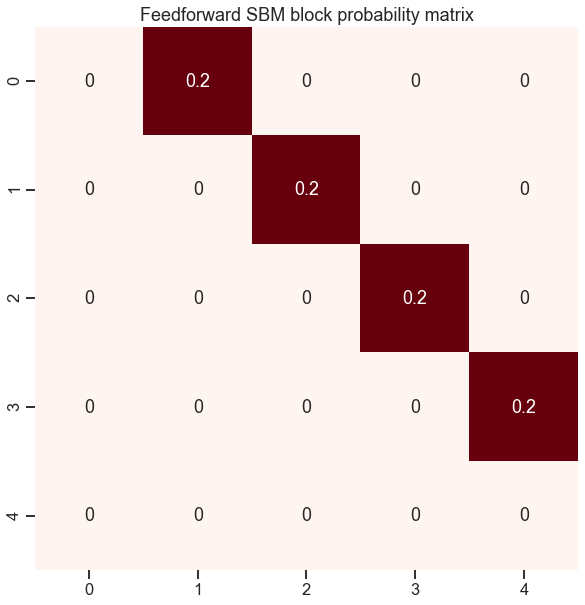

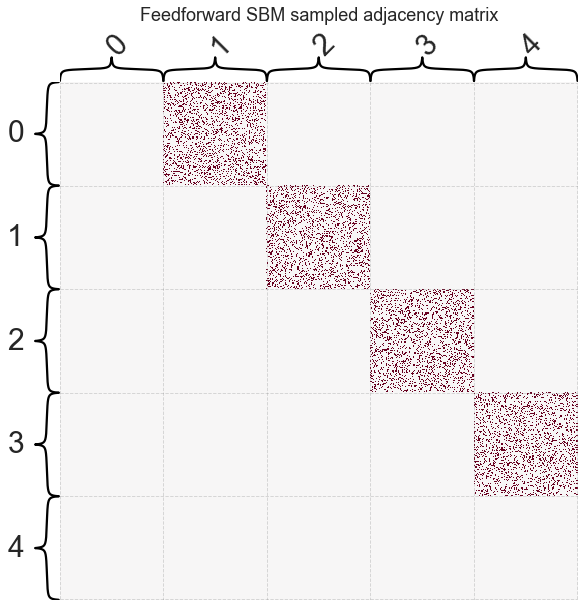

In [2]:
low_p = 0
diag_p = 0
feedforward_p = 0.2
community_sizes = 5 * [100]
B = get_feedforward_B(low_p, diag_p, feedforward_p)

plt.figure(figsize=(10, 10))
plt.title("Feedforward SBM block probability matrix")
sns.heatmap(B, annot=True, square=True, cmap="Reds", cbar=False)
plt.show()

A, labels = sbm(community_sizes, B, directed=True, loops=False, return_labels=True)
labels = labels.astype(str)
heatmap(
    A,
    cbar=False,
    inner_hier_labels=labels,
    title="Feedforward SBM sampled adjacency matrix",
)
plt.show()


 ## Compute the signal flow metrix on the perfect feedforward network
 The energy function that this metric optimizes is for any pair of vertices, make the
 signal flow metric for node $i$ ($z_i$), equal to one greater than that for node $j$
 ($z_j$) if node $i$ is above node $j$ in the hierarchy. The basic intuition is that
 every node in a level of the hierarchy, if it were a perfect hierarchy, would be at
 the same $z$ level, which would be one greater than the $z$ level for the next layer
 in the network.

 Here, this is exactly what we see for the perfect feedforward network. The x-axis here
 is the second laplacian eigenvector (like Figure 2A in Varshney). Note that the order
 of the nodes in the signal flow axis matches the block labels for the simulation we
 set up, and that the hierarchy layers are separated by 1 in the signal flow metric.

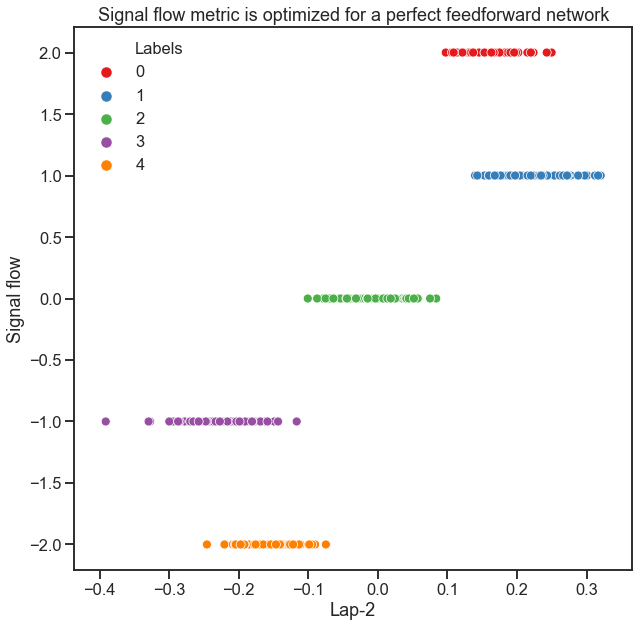

In [3]:
scatter_df = signal_flow(A)
scatter_df["Labels"] = labels


plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="Lap-2",
    y="Signal flow",
    data=scatter_df,
    hue="Labels",
    palette=sns.color_palette("Set1", scatter_df.Labels.nunique()),
)
plt.title("Signal flow metric is optimized for a perfect feedforward network")
plt.show()


 ## Observe what happens when the feedforward motif is no longer perfect
 Here I make the communities have stronger within-community connections and add a small
 probability of connection between any two nodes regardless of community

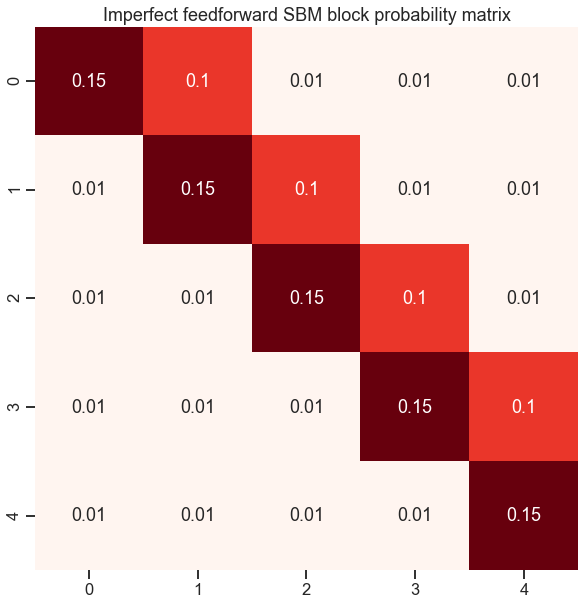

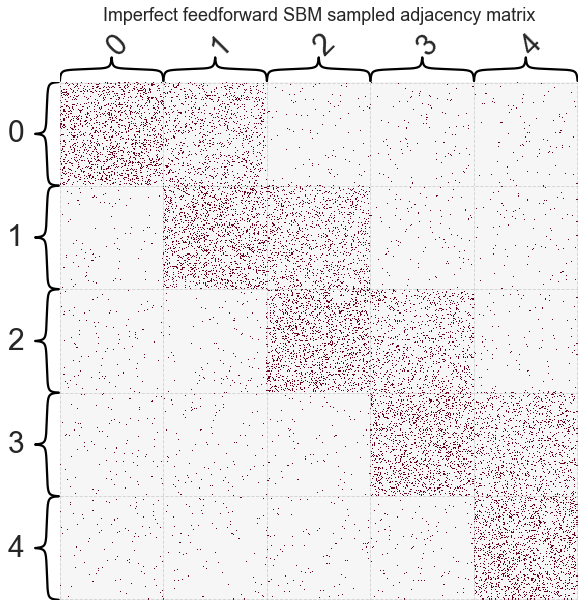

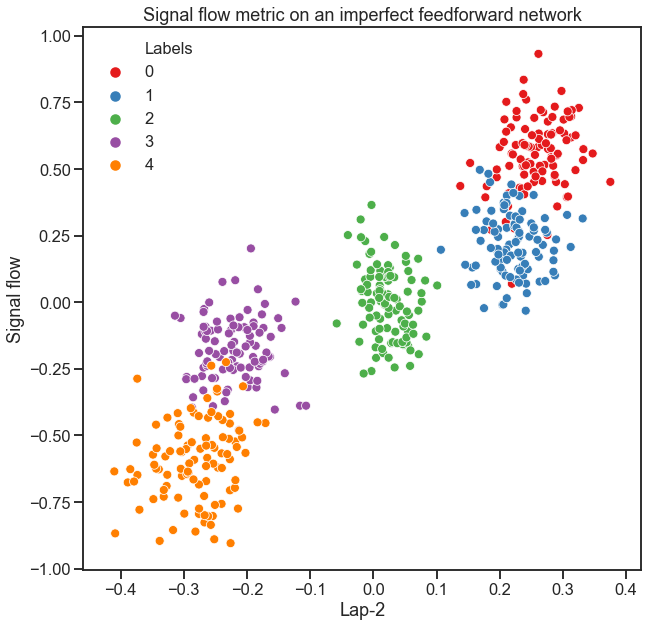

In [4]:
low_p = 0.01
diag_p = 0.15
feedforward_p = 0.1
community_sizes = 5 * [100]
B = get_feedforward_B(low_p, diag_p, feedforward_p)

plt.figure(figsize=(10, 10))
plt.title("Imperfect feedforward SBM block probability matrix")
sns.heatmap(B, annot=True, square=True, cmap="Reds", cbar=False)
plt.show()

A, labels = sbm(community_sizes, B, directed=True, loops=False, return_labels=True)
labels = labels.astype(str)
heatmap(
    A,
    cbar=False,
    inner_hier_labels=labels,
    title="Imperfect feedforward SBM sampled adjacency matrix",
)
plt.show()

scatter_df = signal_flow(A)
scatter_df["Labels"] = labels

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="Lap-2",
    y="Signal flow",
    data=scatter_df,
    hue="Labels",
    palette=sns.color_palette("Set1", scatter_df.Labels.nunique()),
)
plt.title("Signal flow metric on an imperfect feedforward network")
plt.show()


 ## Now, look at the output for this signal flow metric on the A $\rightarrow$ D graph
 Here I am just using labels for MB and PNs, as well as indicating side with the
 direction of the marker

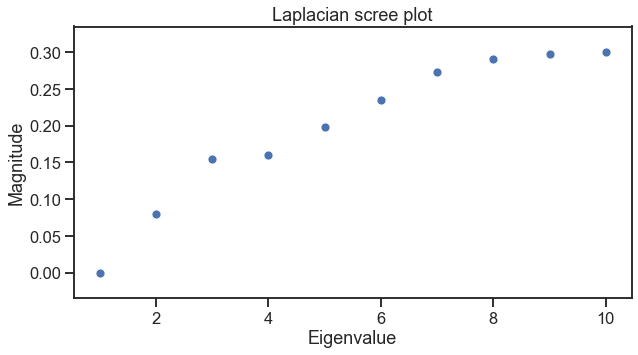

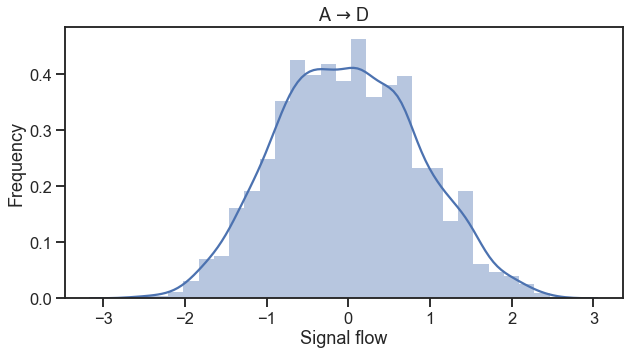

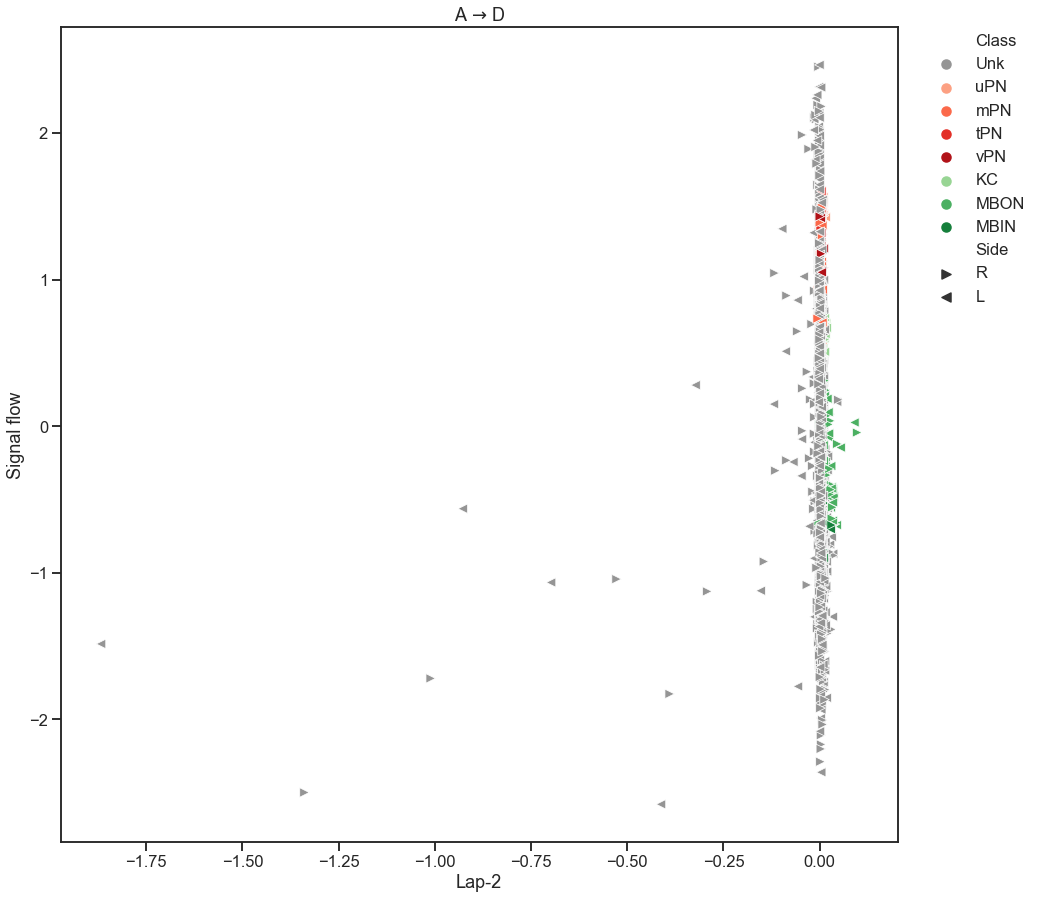

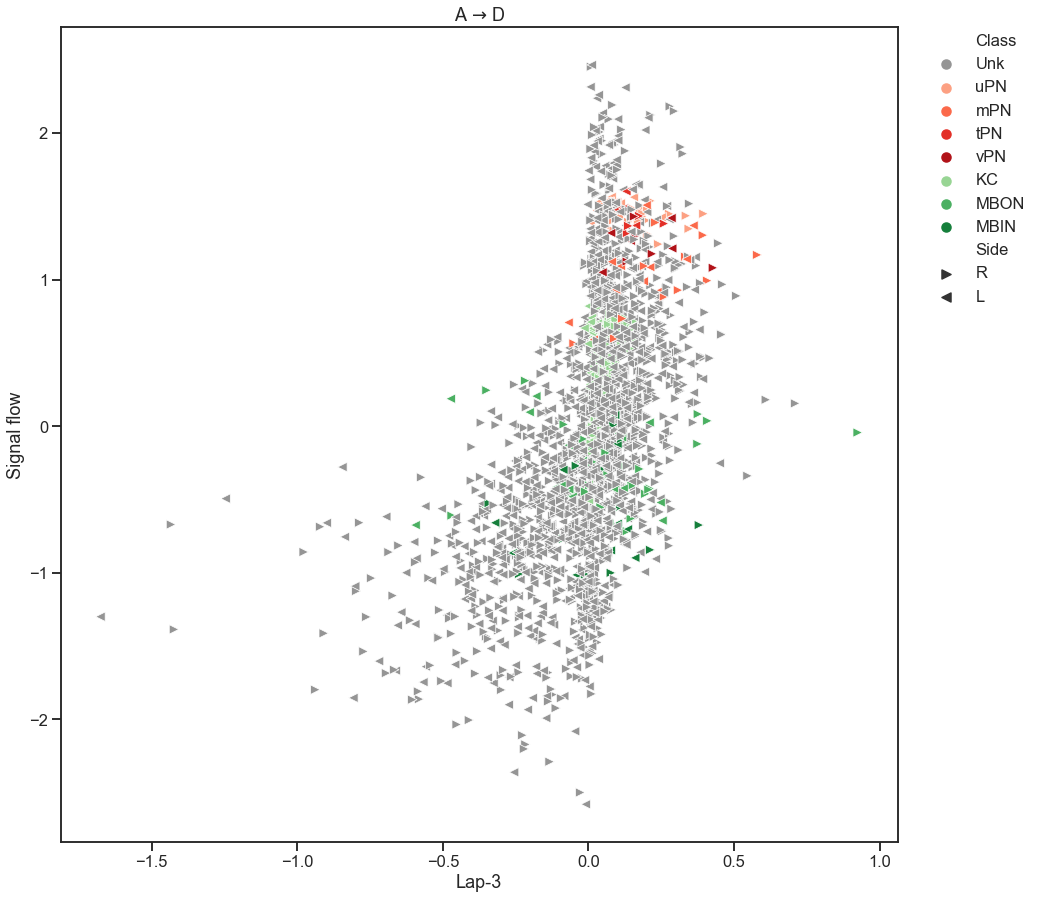

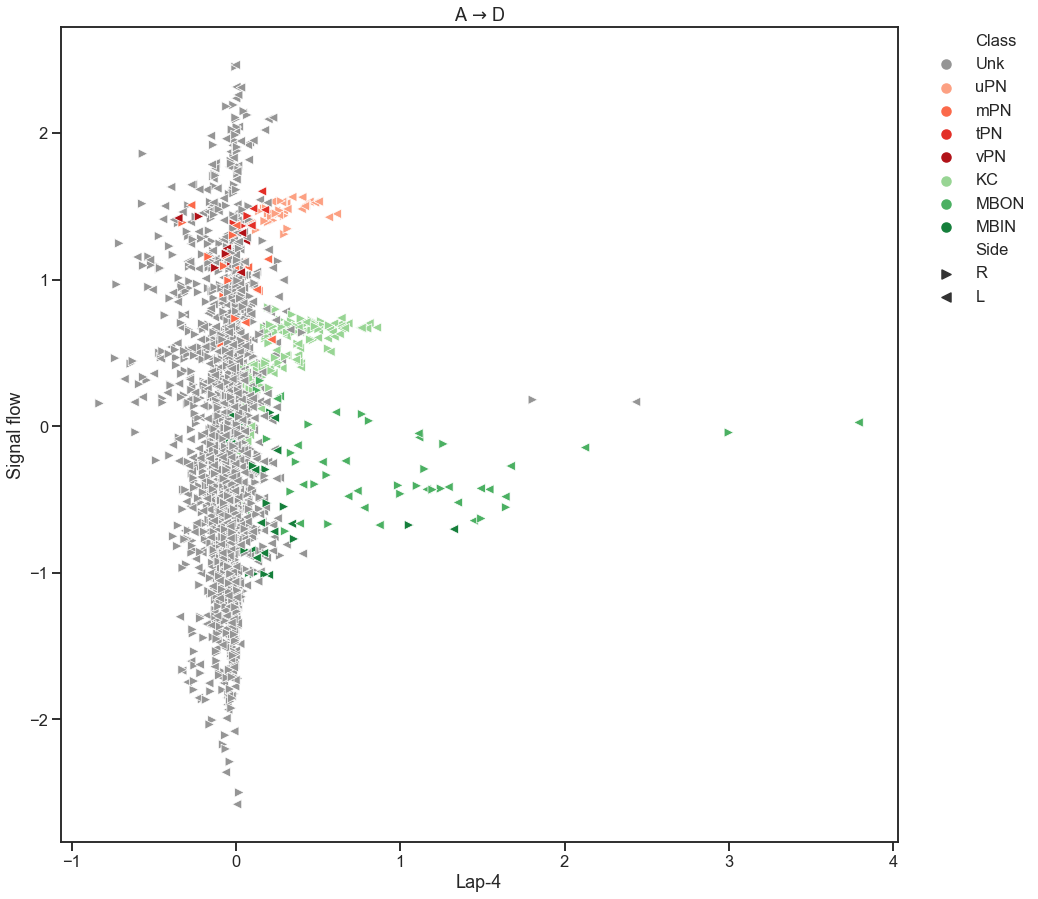

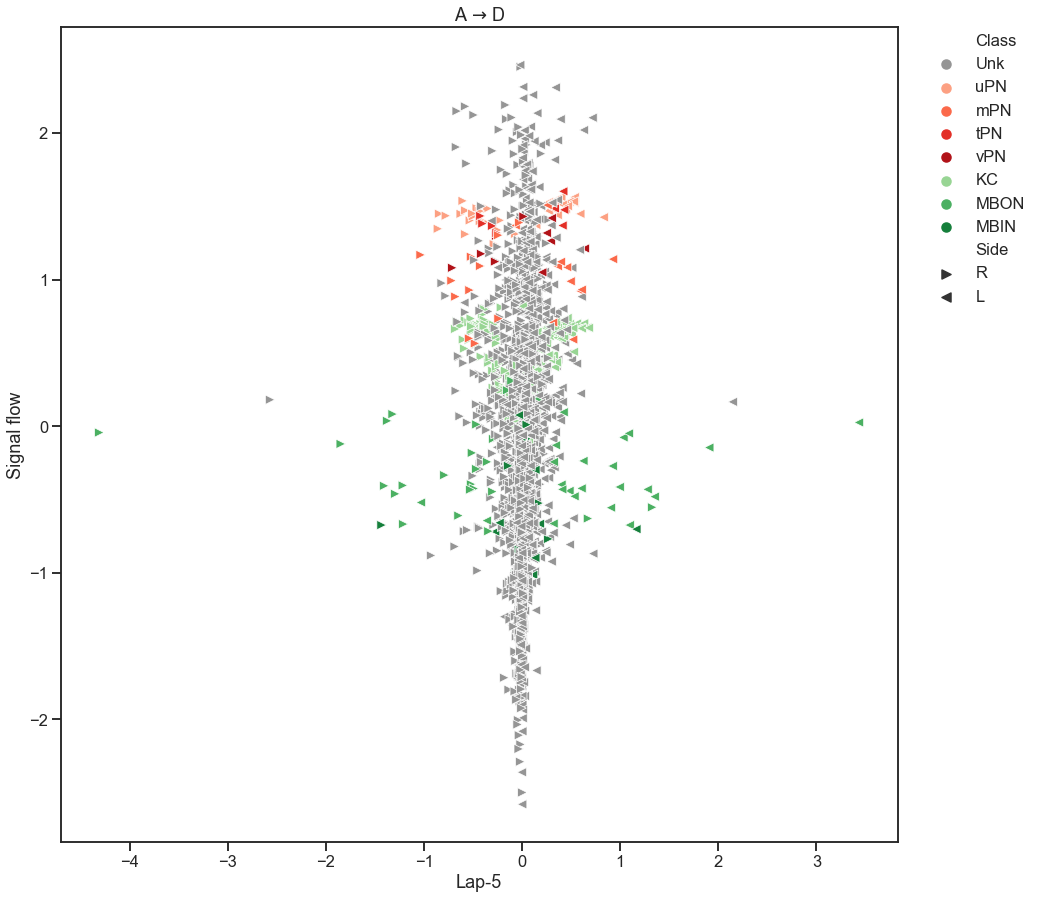

In [5]:
GRAPH_VERSION = "2019-09-18-v2"
adj, class_labels, side_labels = load_everything(
    "Gad", GRAPH_VERSION, return_class=True, return_side=True
)

adj, inds = get_lcc(adj, return_inds=True)
class_labels = class_labels[inds]
side_labels = side_labels[inds]

name_map = {" mw right": "R", " mw left": "L"}
side_labels = np.array(itemgetter(*side_labels)(name_map))

name_map = {
    "CN": "Unk",
    "DANs": "MBIN",
    "KCs": "KC",
    "LHN": "Unk",
    "LHN; CN": "Unk",
    "MBINs": "MBIN",
    "MBON": "MBON",
    "MBON; CN": "MBON",
    "OANs": "MBIN",
    "ORN mPNs": "mPN",
    "ORN uPNs": "uPN",
    "tPNs": "tPN",
    "vPNs": "vPN",
    "Unidentified": "Unk",
    "Other": "Unk",
}
class_labels = np.array(itemgetter(*class_labels)(name_map))

# Construct a custom color palette
total_palette = []
hue_order = []
unk_color = sns.color_palette("Greys", 1, desat=0.2)
total_palette += unk_color
hue_order += ["Unk"]
pn_colors = sns.color_palette("Reds", n_colors=5)[1:]
total_palette += pn_colors
hue_order += ["uPN", "mPN", "tPN", "vPN"]
mb_colors = sns.color_palette("Greens", n_colors=4)[1:]
total_palette += mb_colors
hue_order += ["KC", "MBON", "MBIN"]


# Compute signal flow
scatter_df, evals = signal_flow(adj, return_evals=True)
scatter_df["Class"] = class_labels
scatter_df["Side"] = side_labels

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(range(1, 11), evals[:10])
plt.title("Laplacian scree plot")
plt.xlabel("Eigenvalue")
plt.ylabel("Magnitude")

plt.figure(figsize=(10, 5))
sns.distplot(scatter_df["Signal flow"])
plt.ylabel("Frequency")
plt.title(r"A $\to$ D")


plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D")
sns.scatterplot(
    x="Lap-2",
    y="Signal flow",
    data=scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)

plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D")
sns.scatterplot(
    x="Lap-3",
    y="Signal flow",
    data=scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)

plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D")
sns.scatterplot(
    x="Lap-4",
    y="Signal flow",
    data=scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)

plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D")
sns.scatterplot(
    x="Lap-5",
    y="Signal flow",
    data=scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)
plt.show()


 # Look at why the second laplacian eigenvector looks so sparse

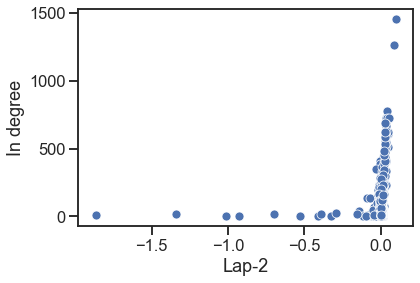

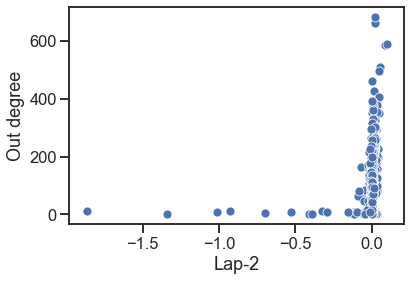

In [6]:
in_degree = np.sum(adj, axis=0)
out_degree = np.sum(adj, axis=1)
plt.figure()
sns.scatterplot(scatter_df["Lap-2"], in_degree)
plt.ylabel("In degree")
plt.figure()
sns.scatterplot(scatter_df["Lap-2"], out_degree)
plt.ylabel("Out degree")
plt.show()


 # Now, do the same but for the sum of A $\rightarrow$ D and A $\rightarrow$ A

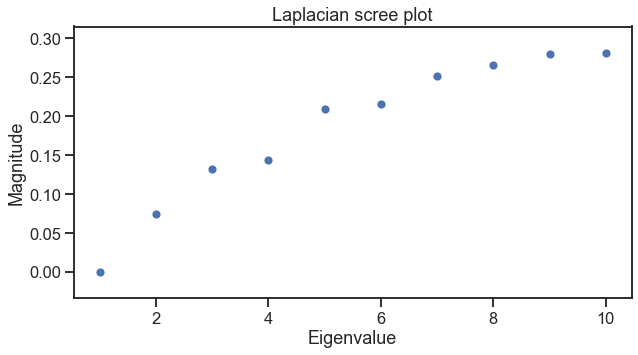

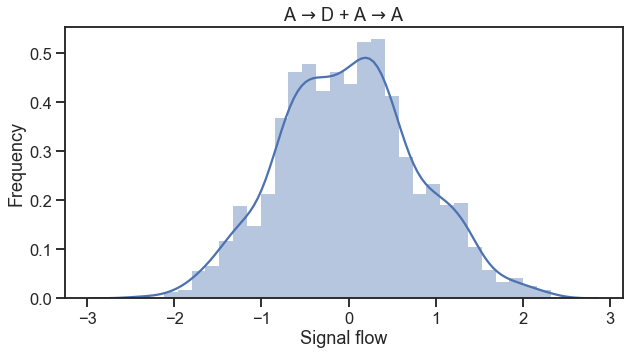

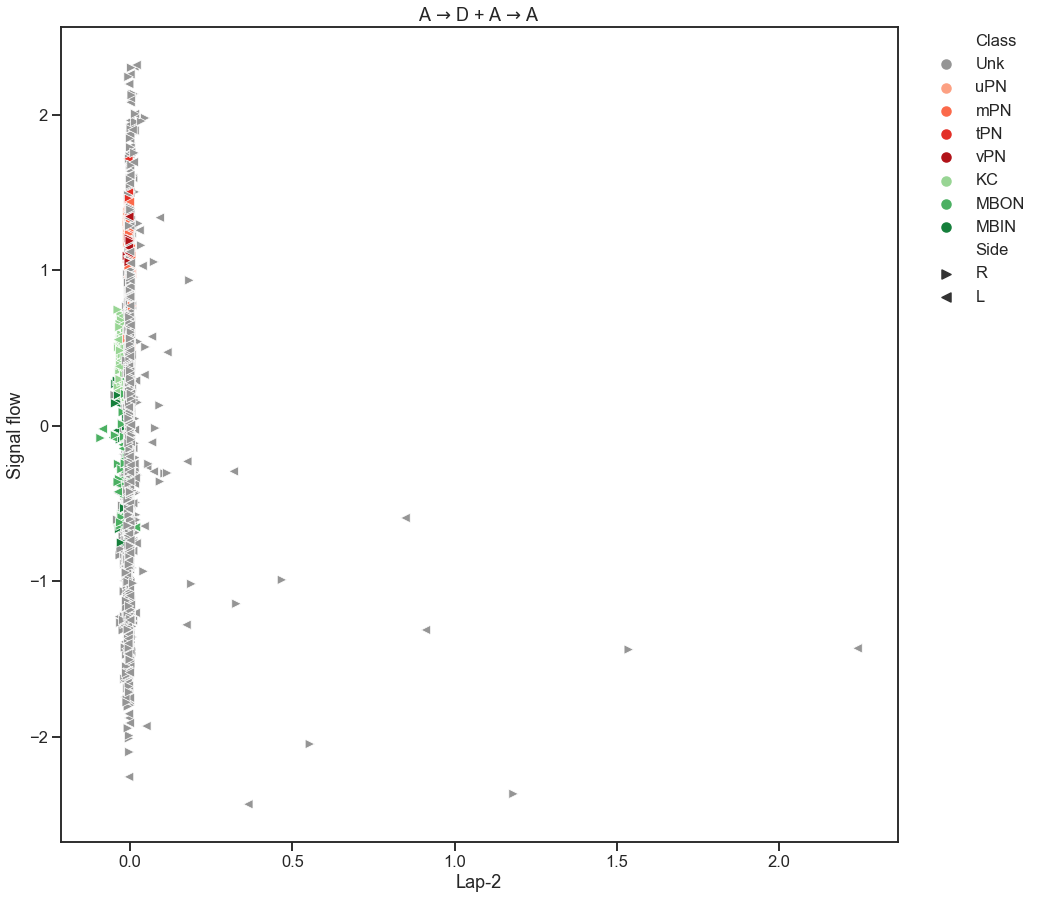

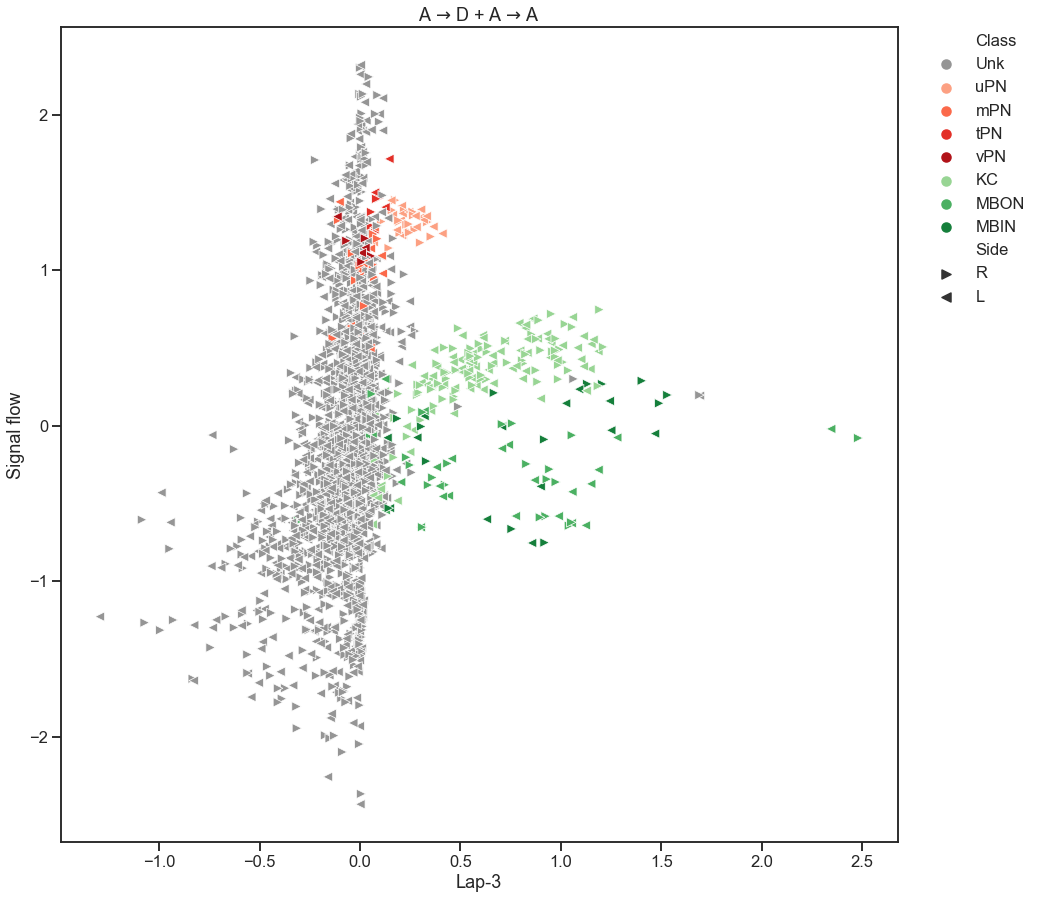

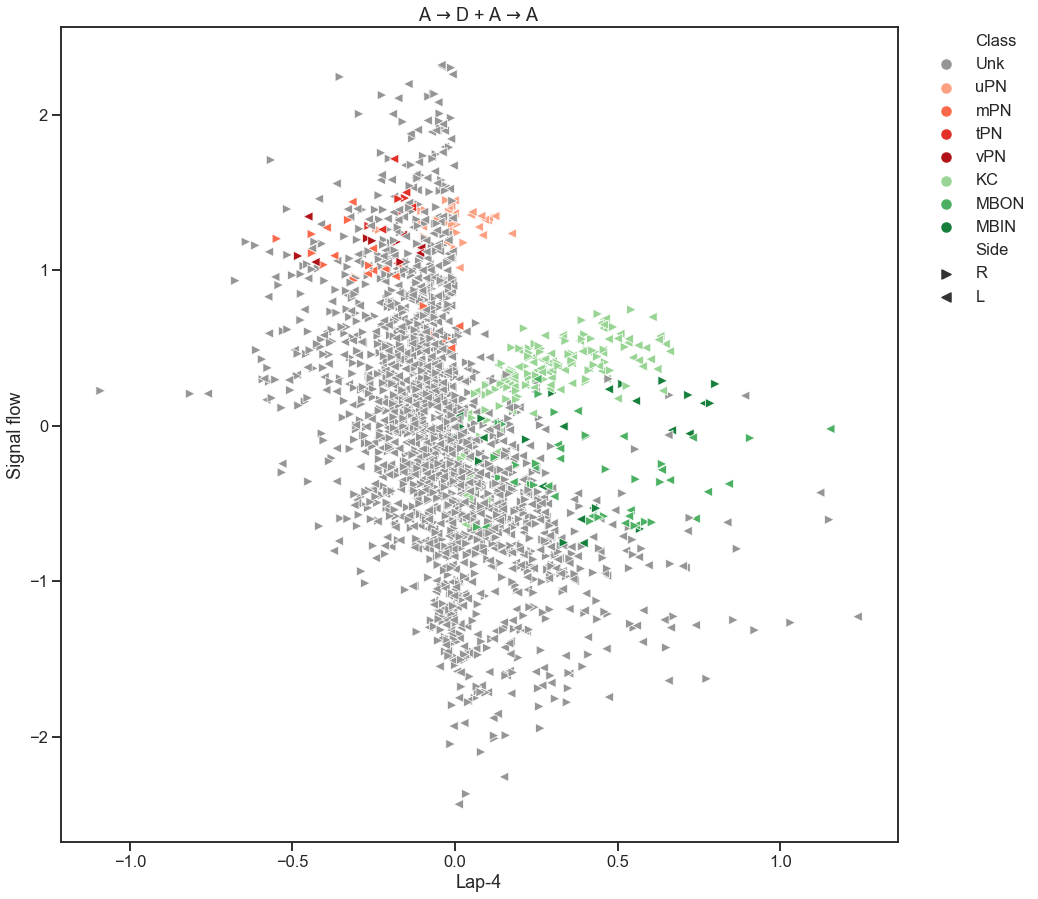

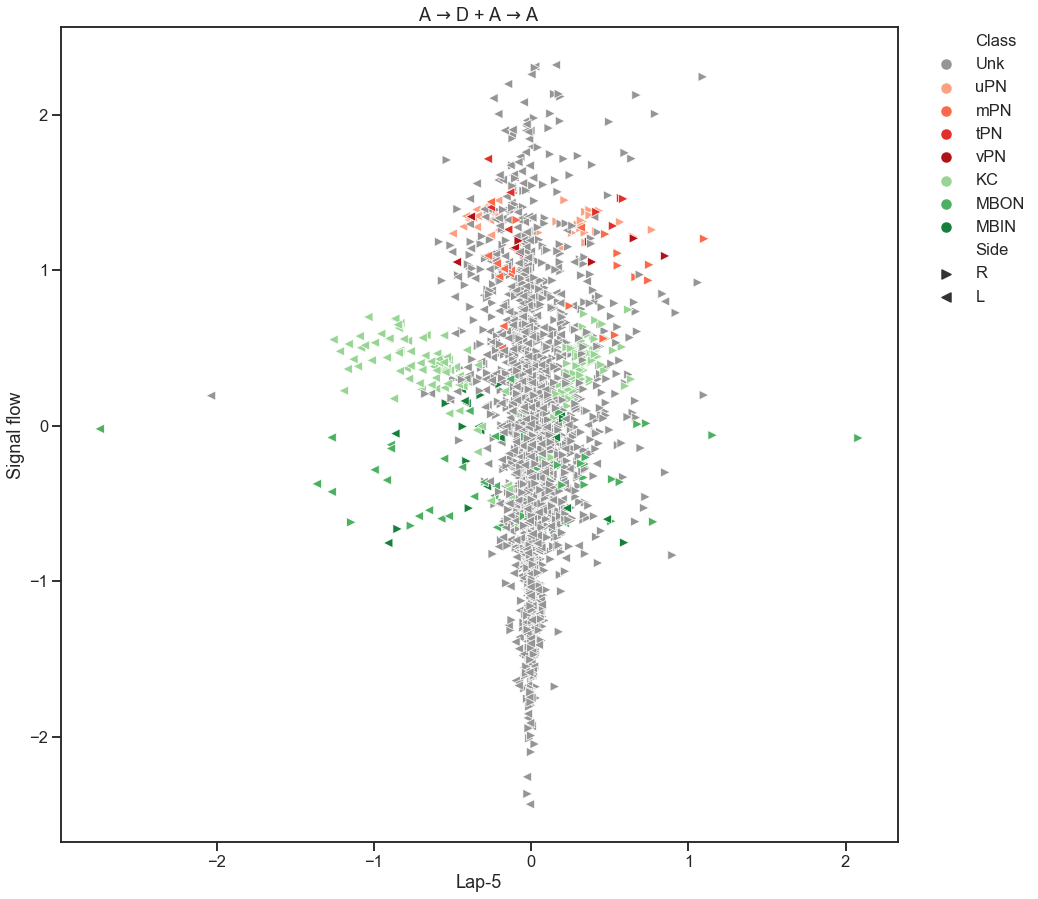

In [7]:
adj_aa = load_everything("Gaa", version=GRAPH_VERSION)
adj_aa = adj_aa[np.ix_(inds, inds)]
adj = adj + adj_aa

# Compute signal flow
aa_scatter_df, evals = signal_flow(adj, return_evals=True)
aa_scatter_df["Class"] = class_labels
aa_scatter_df["Side"] = side_labels

# Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(range(1, 11), evals[:10])
plt.title("Laplacian scree plot")
plt.xlabel("Eigenvalue")
plt.ylabel("Magnitude")

plt.figure(figsize=(10, 5))
sns.distplot(aa_scatter_df["Signal flow"])
plt.ylabel("Frequency")
plt.title(r"A $\to$ D + A $\to$ A")

plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D + A $\to$ A")
sns.scatterplot(
    x="Lap-2",
    y="Signal flow",
    data=aa_scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)

plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D + A $\to$ A")
sns.scatterplot(
    x="Lap-3",
    y="Signal flow",
    data=aa_scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)

plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D + A $\to$ A")
sns.scatterplot(
    x="Lap-4",
    y="Signal flow",
    data=aa_scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)

plt.figure(figsize=(15, 15))
plt.title(r"A $\to$ D + A $\to$ A")
sns.scatterplot(
    x="Lap-5",
    y="Signal flow",
    data=aa_scatter_df,
    hue="Class",
    style="Side",
    markers=[">", "<"],
    palette=total_palette,
    hue_order=hue_order,
    s=90,
    alpha=1,
)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.0)
plt.show()


 ## Now plot the signal flow metric from A $\to$ D vs from A $\to$ D + A $\to$ A
 Would it be worth looking at the cells which move the most? I.e. the cells furthest
 away from y=x

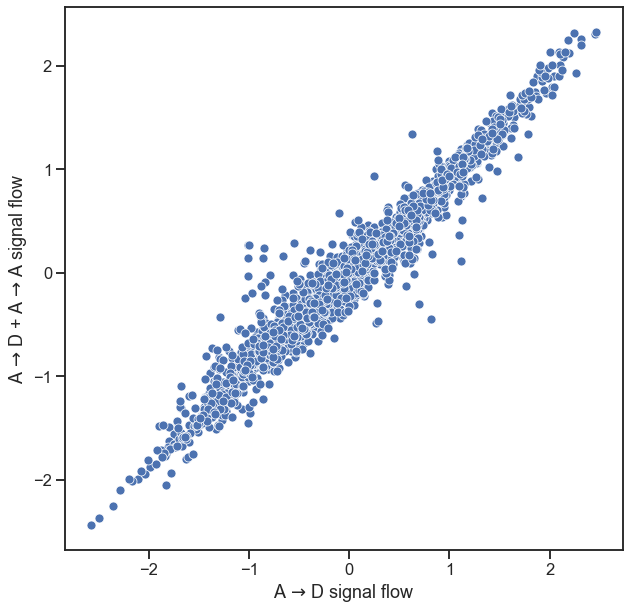

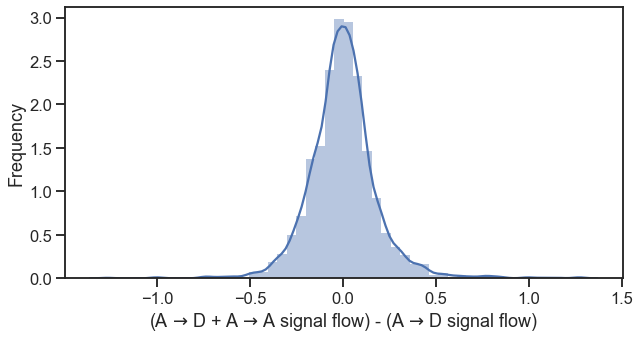

In [8]:
aa_signal = aa_scatter_df["Signal flow"].values
ad_signal = scatter_df["Signal flow"].values

plt.figure(figsize=(10, 10))
sns.scatterplot(ad_signal, aa_signal)
plt.xlabel(r"A $\to$ D signal flow")
plt.ylabel(r"A $\to$ D + A $\to$ A signal flow")
plt.show()

plt.figure(figsize=(10, 5))
sns.distplot(aa_signal - ad_signal)
plt.xlabel(r"(A $\to$ D + A $\to$ A signal flow) - (A $\to$ D signal flow)")
plt.ylabel("Frequency")
plt.show()


 # Look at the different 4-color combinations, compute signal flow on each separately
 Plot the distributions of signal flow for the 4-colors against each other

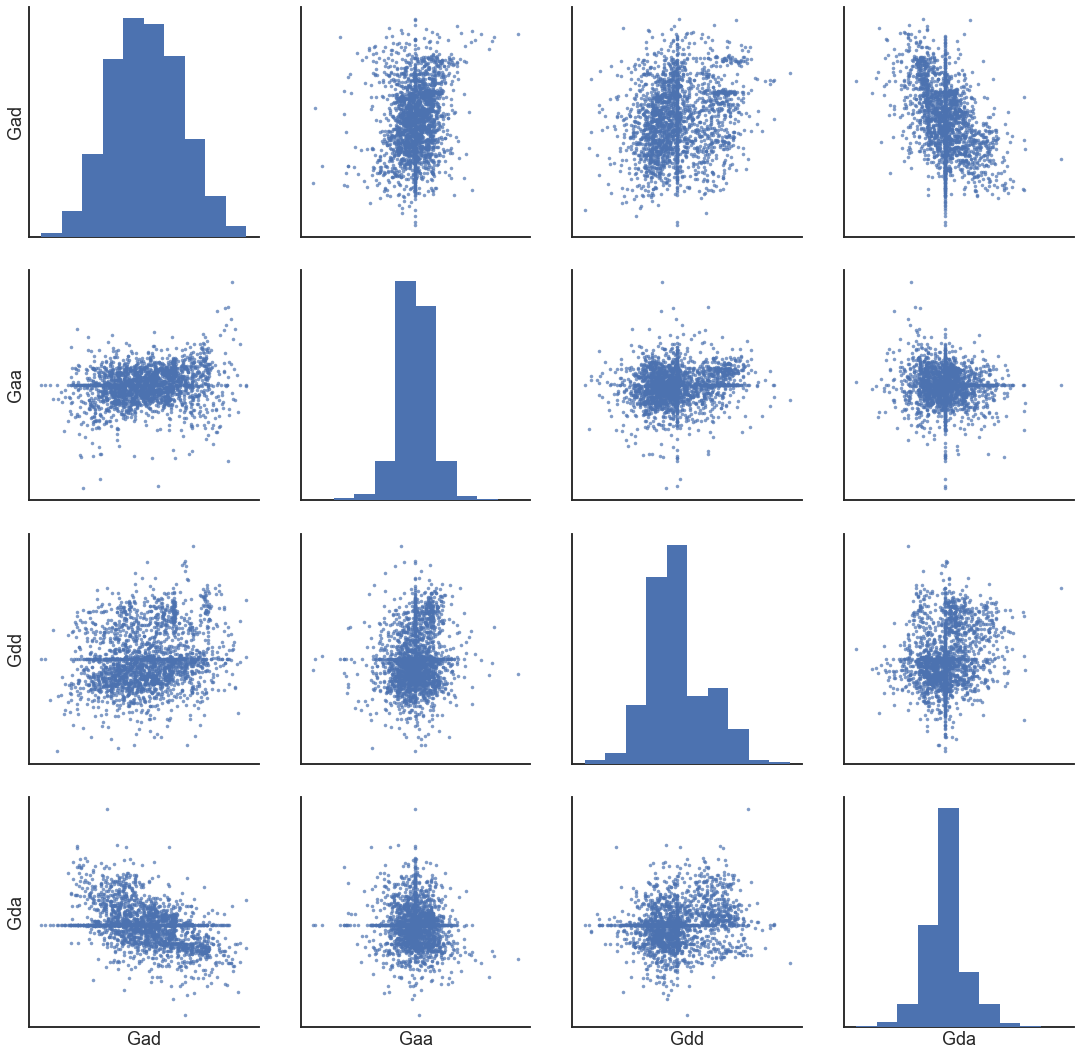

In [9]:
GRAPH_TYPES = ["Gad", "Gaa", "Gdd", "Gda"]

signal_flows = []
for g in GRAPH_TYPES:
    adj = load_everything(g, version=GRAPH_VERSION)
    adj = adj[np.ix_(inds, inds)]
    scatter_df = signal_flow(adj)
    sf = scatter_df["Signal flow"]
    signal_flows.append(sf)


signal_flows = np.array(signal_flows).T
pairplot(signal_flows, col_names=GRAPH_TYPES, height=4)
plt.show()
